# Decision Trees and Ensemble Methods

In this exercise we will run some regression analysis on property data from Boston, freely available in the SciKit Learn datasets collection. The initial model will be a Decision Tree, followed by some ensemble methods. Let's begin by importing the required libraries.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, AdaBoostRegressor

Load the Boston housing dataset, get the keys and read the description.

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

In [3]:
boston.keys()

['data', 'feature_names', 'DESCR', 'target']

In [4]:
print boston.DESCR

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Create a feature matrix by using the data and feature names. Also create a target vector that contains the median property value (MEDV).

In [5]:
X = pd.DataFrame(boston.data, columns = boston.feature_names)
y = pd.Series(boston.target, name = 'MEDV')

In [6]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Rescale the data with the Standard Scaler.

In [7]:
scaler = StandardScaler()

import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning) 

X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns = boston.feature_names)

y_scaled = scaler.fit_transform(y)
y = pd.Series(y_scaled)

Perform a train test split.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

Fit the data using a decision tree regressor and obtain the mean squared and R2 errors.

In [9]:
dtr = DecisionTreeRegressor(max_depth = 3, random_state = 1)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)

print 'Training set'
print 'MSE', mean_squared_error(y_train, dtr.predict(X_train)).round(4)
print 'R2 ', r2_score(y_train, dtr.predict(X_train)).round(4)
print ''
print 'Test set'
print 'MSE', mean_squared_error(y_test, y_pred).round(4)
print 'R2 ', r2_score(y_test, y_pred).round(4)

Training set
MSE 0.1971
R2  0.8112

Test set
MSE 0.2809
R2  0.6867


We can visualise the tree thus.

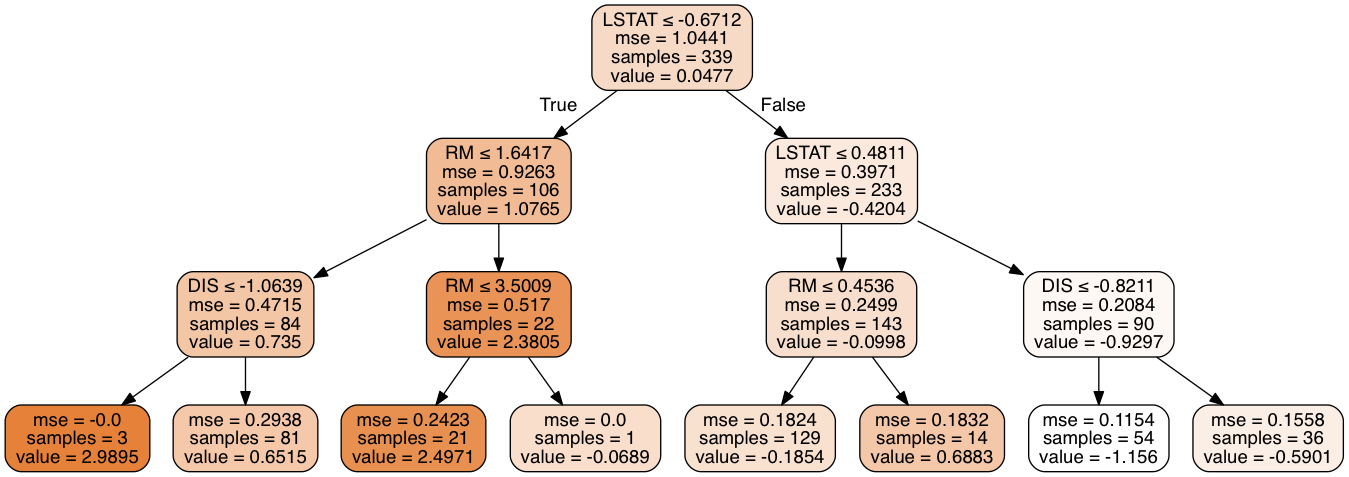

In [10]:
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot
dot_data = StringIO()  
export_graphviz(dtr, out_file = dot_data,  
                feature_names = X.columns,  
                filled = True, rounded = True,  
                special_characters = True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

Now we will use ensemble methods to fit decision trees. For Random Forest, Extra Tree, Bagging and Ada Boost Regressors we will vary the number of estimators. Performance is assessed with five-fold cross validation using *neg_mean_squared_error* scoring.

In [11]:
# Create a function to call later.
def calc_cross_val(model):
    scores = cross_val_score(model, X, y, cv = 5, n_jobs = 1, scoring = 'neg_mean_squared_error')
    return -scores.mean()

In [12]:
# This creates a range of values for the following for statement to loop through.
values = sorted(list(set(np.logspace(0, 3, num = 20, endpoint = True, base = 10.0).astype(int))))

Here we run through the values for each of the various ensembles in what is the computationally heaviest part of the notebook.

In [13]:
score_list = []

for n in values:
    models = [('Random_Forest', RandomForestRegressor(random_state = 1, n_estimators = n)),
              ('Extra_Trees', ExtraTreesRegressor(random_state = 1, n_estimators = n)),
              ('Bagging', BaggingRegressor(random_state = 1, n_estimators = n)),
              ('Ada_Boost', AdaBoostRegressor(random_state = 1, n_estimators = n))]
                  
    for model in models:
        score = calc_cross_val(model[1])
        score_list.append([model[0], n, score])

Create a dataframe.

In [14]:
df_score_list = pd.DataFrame(score_list, columns = ['model', 'estimators', 'mse'])
df_score_list.head(8)

,model,estimators,mse
0,Random_Forest,1,0.415114
1,Extra_Trees,1,0.672560
2,Bagging,1,0.419781
3,Ada_Boost,1,0.408926
4,Random_Forest,2,0.438611
5,Extra_Trees,2,0.397884
6,Bagging,2,0.363526
7,Ada_Boost,2,0.409564


Plot the relationship between MSE and the number of estimators used. To do this we slice the dataframe made above for each of the ensemble methods used.

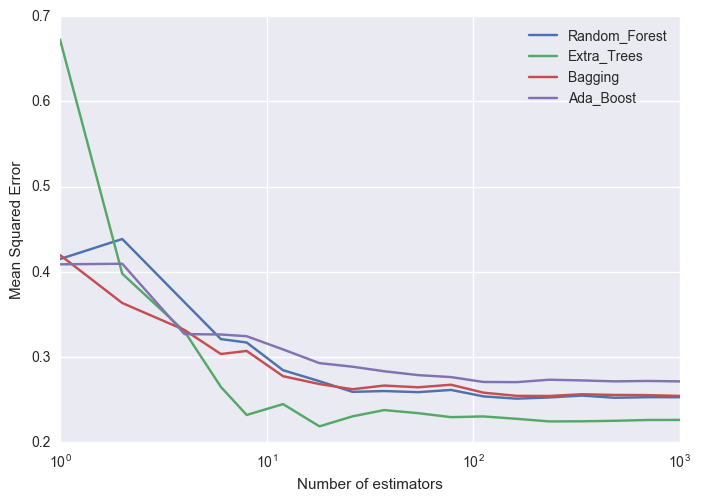

In [15]:
fig, ax = plt.subplots()

for temp in df_score_list.model.unique():
    data = df_score_list[df_score_list['model'] == temp]
    ax.plot(data['estimators'], data['mse'], label = '{}'.format(temp))

plt.xlabel('Number of estimators')
plt.ylabel('Mean Squared Error')
plt.xscale('log')
ax.legend(loc = 'upper right')
plt.show()

The Extra Trees method struggles for lower numbers of estimators but has the lowest MSE of all ensemble methods for higher numbers of estimators. Bagging and Random Forests converge to similar error sizes further up the horizontal axis but Bagging is the better of the two for a low number of estimators. Bagging also has the smoothest profile of all the ensembles. Ada Boost doesn't seem to outperform the others at any part of the graph.